In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

# !PIP

# ResNet50

In [3]:
import torch
import torch.nn as nn
from torch.hub import load_state_dict_from_url
#from torchvision.models.utils import load_state_dict_from_url


__all__ = ['ResNet', 'resnet50']


model_urls = {
    'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
}


def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(BasicBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError('BasicBlock only supports groups=1 and base_width=64')
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(Bottleneck, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=1000, zero_init_residual=False,
                 groups=1, width_per_group=64, replace_stride_with_dilation=None,
                 norm_layer=None):
        super(ResNet, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation should be None "
                             "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2,
                                       dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
                                       dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2,
                                       dilate=replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1, dilate=False):
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, previous_dilation, norm_layer))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, dilation=self.dilation,
                                norm_layer=norm_layer))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

def _resnet(arch, block, layers, pretrained, progress, **kwargs):
    model = ResNet(block, layers, **kwargs)
    if pretrained:
        state_dict = load_state_dict_from_url(model_urls[arch],
                                              progress=progress)
        model.load_state_dict(state_dict)
    return model

def resnet50(pretrained=True, progress=True, **kwargs):
    r"""ResNet-50 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet50', Bottleneck, [3, 4, 6, 3], pretrained, progress,
                   **kwargs)

# Model

In [4]:
class Conv2D(nn.Module):
    def __init__(self, in_c, out_c, kernel_size=3, padding=1, stride=1, dilation=1, bias=True, act=True):
        super().__init__()

        self.act = act
        self.conv = nn.Sequential(
            nn.Conv2d(in_c, out_c, kernel_size, padding=padding, dilation=dilation, stride=stride, bias=bias),
            nn.BatchNorm2d(out_c)
        )
        self.relu = nn.LeakyReLU(negative_slope=0.1, inplace=True)

    def forward(self, x):
        x = self.conv(x)
        if self.act == True:
            x = self.relu(x)
        return x

class residual_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(in_c, out_c, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_c),
            nn.LeakyReLU(negative_slope=0.1, inplace=True),
            nn.Conv2d(out_c, out_c, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_c)
        )
        self.shortcut = nn.Sequential(
            nn.Conv2d(in_c, out_c, kernel_size=1, padding=0),
            nn.BatchNorm2d(out_c)
        )
        self.relu = nn.LeakyReLU(negative_slope=0.1, inplace=True)

    def forward(self, inputs):
        x = self.conv(inputs)
        s = self.shortcut(inputs)
        return self.relu(x + s)

class residual_transformer_block(nn.Module):
    def __init__(self, in_c, out_c, patch_size=4, num_heads=4, num_layers=2, dim=None):
        super().__init__()

        self.ps = patch_size
        self.c1 = Conv2D(in_c, out_c)

        encoder_layer = nn.TransformerEncoderLayer(d_model=dim, nhead=num_heads)
        self.te = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.c2 = Conv2D(out_c, out_c, kernel_size=1, padding=0, act=False)
        self.c3 = Conv2D(in_c, out_c, kernel_size=1, padding=0, act=False)
        self.relu = nn.LeakyReLU(negative_slope=0.1, inplace=True)
        self.r1 = residual_block(out_c, out_c)

    def forward(self, inputs):
        x = self.c1(inputs)

        b, c, h, w = x.shape
        num_patches = (h*w)//(self.ps**2)
        x = torch.reshape(x, (b, (self.ps**2)*c, num_patches))
        x = self.te(x)
        x = torch.reshape(x, (b, c, h, w))

        x = self.c2(x)
        s = self.c3(inputs)
        x = self.relu(x + s)
        x = self.r1(x)
        return x

class Model(nn.Module):
    def __init__(self):
        super().__init__()

        """ Encoder """
        backbone = resnet50()
        self.layer0 = nn.Sequential(backbone.conv1, backbone.bn1, backbone.relu)
        self.layer1 = nn.Sequential(backbone.maxpool, backbone.layer1)
        self.layer2 = backbone.layer2
        self.layer3 = backbone.layer3
        self.layer4 = backbone.layer4

        self.e1 = Conv2D(64, 64, kernel_size=1, padding=0)
        self.e2 = Conv2D(256, 64, kernel_size=1, padding=0)
        self.e3 = Conv2D(512, 64, kernel_size=1, padding=0)
        self.e4 = Conv2D(1024, 64, kernel_size=1, padding=0)


        """ Decoder """
        self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.r1 = residual_transformer_block(64+64, 64, dim=64)
        self.r2 = residual_transformer_block(64+64, 64, dim=256)
        self.r3 = residual_block(64+64, 64)

        """ Classifier """
        self.outputs = nn.Conv2d(64, 1, kernel_size=1, padding=0)

    def forward(self, inputs):
        """ Encoder """
        x0 = inputs
        x1 = self.layer0(x0)    ## [-1, 64, h/2, w/2]
        x2 = self.layer1(x1)    ## [-1, 256, h/4, w/4]
        x3 = self.layer2(x2)    ## [-1, 512, h/8, w/8]
        x4 = self.layer3(x3)    ## [-1, 1024, h/16, w/16]
        # print(x1.shape, x2.shape, x3.shape, x4.shape)

        e1 = self.e1(x1)
        e2 = self.e2(x2)
        e3 = self.e3(x3)
        e4 = self.e4(x4)

        """ Decoder """
        x = self.up(e4)
        x = torch.cat([x, e3], axis=1)
        x = self.r1(x)

        x = self.up(x)
        x = torch.cat([x, e2], axis=1)
        x = self.r2(x)

        x = self.up(x)
        x = torch.cat([x, e1], axis=1)
        x = self.r3(x)

        x = self.up(x)

        """ Classifier """
        outputs = self.outputs(x)
        return outputs

if __name__ == "__main__":
    x = torch.randn((4, 3, 256, 256))
    model = Model()
    y = model(x)
    print(y.shape)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 258MB/s]
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


torch.Size([4, 1, 256, 256])


# Metrics

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from scipy.spatial.distance import directed_hausdorff

""" Loss Functions -------------------------------------- """
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        inputs = torch.sigmoid(inputs)

        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)

        return 1 - dice

class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        inputs = torch.sigmoid(inputs)

        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        Dice_BCE = BCE + dice_loss

        return Dice_BCE

""" Metrics ------------------------------------------ """
def precision(y_true, y_pred):
    intersection = (y_true * y_pred).sum()
    return (intersection + 1e-15) / (y_pred.sum() + 1e-15)

def recall(y_true, y_pred):
    intersection = (y_true * y_pred).sum()
    return (intersection + 1e-15) / (y_true.sum() + 1e-15)

def F2(y_true, y_pred, beta=2):
    p = precision(y_true,y_pred)
    r = recall(y_true, y_pred)
    return (1+beta**2.) *(p*r) / float(beta**2*p + r + 1e-15)

def dice_score(y_true, y_pred):
    return (2 * (y_true * y_pred).sum() + 1e-15) / (y_true.sum() + y_pred.sum() + 1e-15)

def jac_score(y_true, y_pred):
    intersection = (y_true * y_pred).sum()
    union = y_true.sum() + y_pred.sum() - intersection
    return (intersection + 1e-15) / (union + 1e-15)

## https://www.kaggle.com/competitions/uw-madison-gi-tract-image-segmentation/discussion/319452
def hd_dist(preds, targets):
    haussdorf_dist = directed_hausdorff(preds, targets)[0]
    return haussdorf_dist

# Utils

In [6]:
import os
import random
import numpy as np
import cv2
from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score, confusion_matrix

""" Seeding the randomness. """
def seeding(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

""" Create a directory """
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

""" Shuffle the dataset. """
def shuffling(x, y):
    x, y = shuffle(x, y, random_state=42)
    return x, y

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

def print_and_save(file_path, data_str):
    print(data_str)
    with open(file_path, "a") as file:
        file.write(data_str)
        file.write("\n")

def calculate_metrics(y_true, y_pred):
    y_true = y_true.detach().cpu().numpy()
    y_pred = y_pred.detach().cpu().numpy()

    y_pred = y_pred > 0.5
    y_pred = y_pred.reshape(-1)
    y_pred = y_pred.astype(np.uint8)

    y_true = y_true > 0.5
    y_true = y_true.reshape(-1)
    y_true = y_true.astype(np.uint8)

    ## Score
    score_jaccard = jac_score(y_true, y_pred)
    score_f1 = dice_score(y_true, y_pred)
    score_recall = recall(y_true, y_pred)
    score_precision = precision(y_true, y_pred)
    score_fbeta = F2(y_true, y_pred)
    score_acc = accuracy_score(y_true, y_pred)

    return [score_jaccard, score_f1, score_recall, score_precision, score_acc, score_fbeta]

# Train

In [8]:
import random
import time
import datetime
import numpy as np
import albumentations as A
import cv2
from PIL import Image
from glob import glob
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import tensorflow as tf
from sklearn.model_selection import train_test_split

def load_names(path, file_path):
    f = open(file_path, "r")
    data = f.read().split("\n")[:-1]
    images = [os.path.join(path,"images", name) + ".jpg" for name in data]
    masks = [os.path.join(path,"masks", name) + ".jpg" for name in data]
    return images, masks

def load_data(path, split=(0.7, 0.15, 0.15)):
    images = sorted(glob(os.path.join(path, "images/*")))
    masks = sorted(glob(os.path.join(path, "masks/*")))

    # Splitting images and masks into training and validation sets
    train_x, test_x, train_y, test_y = train_test_split(images, masks, test_size=split[2], random_state=42)
    train_x, valid_x, train_y, valid_y = train_test_split(train_x, train_y, test_size=split[1]/(split[0]+split[1]), random_state=42)

    return (train_x, train_y), (valid_x, valid_y), (test_x, test_y)

# def load_data(path, split= 0.15):

#     images = sorted(glob(os.path.join(path, "images/*")))
#     masks = sorted(glob(os.path.join(path, "masks/*")))

#     total_size = len(images)
#     valid_size = int(split * total_size)

#     train_x, valid_x = train_test_split(images, test_size=valid_size, random_state=42)
#     train_y, valid_y = train_test_split(masks, test_size=valid_size, random_state=42)

#     return (train_x, train_y), (valid_x, valid_y)

class DATASET(Dataset):
    def __init__(self, images_path, masks_path, size, transform=None):
        super().__init__()

        self.images_path = images_path
        self.masks_path = masks_path
        self.transform = transform
        self.n_samples = len(images_path)

    def __getitem__(self, index):
        """ Image """
        image = cv2.imread(self.images_path[index], cv2.IMREAD_COLOR)
        mask = cv2.imread(self.masks_path[index], cv2.IMREAD_GRAYSCALE)

        if self.transform is not None:
            augmentations = self.transform(image=image, mask=mask)
            image = augmentations["image"]
            mask = augmentations["mask"]

        image = cv2.resize(image, size)
        image = np.transpose(image, (2, 0, 1))
        image = image/255.0

        mask = cv2.resize(mask, size)
        mask = np.expand_dims(mask, axis=0)
        mask = mask/255.0

        return image, mask

    def __len__(self):
        return self.n_samples

def train(model, loader, optimizer, loss_fn, device):
    model.train()

    epoch_loss = 0.0
    epoch_jac = 0.0
    epoch_f1 = 0.0
    epoch_recall = 0.0
    epoch_precision = 0.0

    for i, (x, y) in enumerate(loader):
        x = x.to(device, dtype=torch.float32)
        y = y.to(device, dtype=torch.float32)

        optimizer.zero_grad()
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

        """ Calculate the metrics """
        batch_jac = []
        batch_f1 = []
        batch_recall = []
        batch_precision = []

        for yt, yp in zip(y, y_pred):
            score = calculate_metrics(yt, yp)
            batch_jac.append(score[0])
            batch_f1.append(score[1])
            batch_recall.append(score[2])
            batch_precision.append(score[3])

        epoch_jac += np.mean(batch_jac)
        epoch_f1 += np.mean(batch_f1)
        epoch_recall += np.mean(batch_recall)
        epoch_precision += np.mean(batch_precision)

    epoch_loss = epoch_loss/len(loader)
    epoch_jac = epoch_jac/len(loader)
    epoch_f1 = epoch_f1/len(loader)
    epoch_recall = epoch_recall/len(loader)
    epoch_precision = epoch_precision/len(loader)

    return epoch_loss, [epoch_jac, epoch_f1, epoch_recall, epoch_precision]

def evaluate(model, loader, loss_fn, device):
    model.eval()

    epoch_loss = 0
    epoch_loss = 0.0
    epoch_jac = 0.0
    epoch_f1 = 0.0
    epoch_recall = 0.0
    epoch_precision = 0.0

    with torch.no_grad():
        for i, (x, y) in enumerate(loader):
            x = x.to(device, dtype=torch.float32)
            y = y.to(device, dtype=torch.float32)

            y_pred = model(x)
            loss = loss_fn(y_pred, y)
            epoch_loss += loss.item()

            """ Calculate the metrics """
            batch_jac = []
            batch_f1 = []
            batch_recall = []
            batch_precision = []

            for yt, yp in zip(y, y_pred):
                score = calculate_metrics(yt, yp)
                batch_jac.append(score[0])
                batch_f1.append(score[1])
                batch_recall.append(score[2])
                batch_precision.append(score[3])

            epoch_jac += np.mean(batch_jac)
            epoch_f1 += np.mean(batch_f1)
            epoch_recall += np.mean(batch_recall)
            epoch_precision += np.mean(batch_precision)

        epoch_loss = epoch_loss/len(loader)
        epoch_jac = epoch_jac/len(loader)
        epoch_f1 = epoch_f1/len(loader)
        epoch_recall = epoch_recall/len(loader)
        epoch_precision = epoch_precision/len(loader)

        return epoch_loss, [epoch_jac, epoch_f1, epoch_recall, epoch_precision]

if __name__ == "__main__":
    """ Seeding """
    seeding(42)

    """ Directories """
    create_dir("files")

    """ Training logfile """
    train_log_path = "files/train_log.txt"
    if os.path.exists(train_log_path):
        print("Log file exists")
    else:
        train_log = open("files/train_log.txt", "w")
        train_log.write("\n")
        train_log.close()

    """ Record Date & Time """
    datetime_object = str(datetime.datetime.now())
    print_and_save(train_log_path, datetime_object)
    print("")

    """ Hyperparameters """
    image_size = 256
    size = (image_size, image_size)
    batch_size = 8
    num_epochs = 20
    lr = 1e-4
    early_stopping_patience = 50
    checkpoint_path = "files/checkpoint.pth"
    path = "/content/drive/MyDrive/D_Polyp/Polyp/Data/kvasir-seg/Kvasir-SEG"


    data_str = f"Image Size: {size}\nBatch Size: {batch_size}\nLR: {lr}\nEpochs: {num_epochs}\n"
    data_str += f"Early Stopping Patience: {early_stopping_patience}\n"
    print_and_save(train_log_path, data_str)

    """ Dataset """
    (train_x, train_y), (valid_x, valid_y), (test_x, valid_y) = load_data(path)
    train_x, train_y = shuffling(train_x, train_y)
    data_str = f"Dataset Size:\nTrain: {len(train_x)} - Valid: {len(valid_x)}\n"
    print_and_save(train_log_path, data_str)

    """ Data augmentation: Transforms """
    transform =  A.Compose([
        A.Rotate(limit=35, p=0.3),
        A.HorizontalFlip(p=0.3),
        A.VerticalFlip(p=0.3),
        A.CoarseDropout(p=0.3, max_holes=10, max_height=32, max_width=32)
    ])

    """ Dataset and loader """
    train_dataset = DATASET(train_x, train_y, size, transform=transform)
    valid_dataset = DATASET(valid_x, valid_y, size, transform=None)

    train_loader = DataLoader(
        dataset=train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=2
    )

    valid_loader = DataLoader(
        dataset=valid_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=2
    )

    """ Model """
    device = torch.device('cuda')
    model = Model()
    model = model.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, verbose=True)
    loss_fn = DiceBCELoss()
    loss_name = "BCE Dice Loss"
    data_str = f"Optimizer: Adam\nLoss: {loss_name}\n"
    print_and_save(train_log_path, data_str)

    """ Training the model """
    best_valid_metrics = 0.0
    early_stopping_count = 0

    for epoch in range(num_epochs):
        start_time = time.time()

        train_loss, train_metrics = train(model, train_loader, optimizer, loss_fn, device)
        valid_loss, valid_metrics = evaluate(model, valid_loader, loss_fn, device)
        scheduler.step(valid_loss)

        if valid_metrics[1] > best_valid_metrics:
            data_str = f"Valid F1 improved from {best_valid_metrics:2.4f} to {valid_metrics[1]:2.4f}. Saving checkpoint: {checkpoint_path}"
            print_and_save(train_log_path, data_str)

            best_valid_metrics = valid_metrics[1]
            torch.save(model.state_dict(), checkpoint_path)
            early_stopping_count = 0

        elif valid_metrics[1] < best_valid_metrics:
            early_stopping_count += 1

        end_time = time.time()
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)

        data_str = f"Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s\n"
        data_str += f"\tTrain Loss: {train_loss:.4f} - Jaccard: {train_metrics[0]:.4f} - F1: {train_metrics[1]:.4f} - Recall: {train_metrics[2]:.4f} - Precision: {train_metrics[3]:.4f}\n"
        data_str += f"\t Val. Loss: {valid_loss:.4f} - Jaccard: {valid_metrics[0]:.4f} - F1: {valid_metrics[1]:.4f} - Recall: {valid_metrics[2]:.4f} - Precision: {valid_metrics[3]:.4f}\n"
        print_and_save(train_log_path, data_str)

        if early_stopping_count == early_stopping_patience:
            data_str = f"Early stopping: validation loss stops improving from last {early_stopping_patience} continously.\n"
            print_and_save(train_log_path, data_str)
            break

Log file exists
2024-06-25 10:32:10.450348

Image Size: (256, 256)
Batch Size: 8
LR: 0.0001
Epochs: 20
Early Stopping Patience: 50

Dataset Size:
Train: 700 - Valid: 150



/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Optimizer: Adam
Loss: BCE Dice Loss



/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Valid F1 improved from 0.0000 to 0.2440. Saving checkpoint: files/checkpoint.pth
Epoch: 01 | Epoch Time: 3m 10s
	Train Loss: 0.8317 - Jaccard: 0.5786 - F1: 0.6965 - Recall: 0.8054 - Precision: 0.6965
	 Val. Loss: 1.5993 - Jaccard: 0.1565 - F1: 0.2440 - Recall: 0.3327 - Precision: 0.3038



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 02 | Epoch Time: 0m 34s
	Train Loss: 0.5372 - Jaccard: 0.7176 - F1: 0.8125 - Recall: 0.8534 - Precision: 0.8407
	 Val. Loss: 1.7269 - Jaccard: 0.1464 - F1: 0.2299 - Recall: 0.3047 - Precision: 0.3116



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 03 | Epoch Time: 0m 32s
	Train Loss: 0.4506 - Jaccard: 0.7492 - F1: 0.8366 - Recall: 0.8584 - Precision: 0.8673
	 Val. Loss: 1.7274 - Jaccard: 0.1461 - F1: 0.2293 - Recall: 0.3079 - Precision: 0.3056



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 04 | Epoch Time: 0m 32s
	Train Loss: 0.3824 - Jaccard: 0.7693 - F1: 0.8506 - Recall: 0.8656 - Precision: 0.8823
	 Val. Loss: 1.7067 - Jaccard: 0.1428 - F1: 0.2242 - Recall: 0.2918 - Precision: 0.3215



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 05 | Epoch Time: 0m 34s
	Train Loss: 0.3378 - Jaccard: 0.7865 - F1: 0.8638 - Recall: 0.8746 - Precision: 0.8995
	 Val. Loss: 2.0105 - Jaccard: 0.1475 - F1: 0.2327 - Recall: 0.3210 - Precision: 0.2979



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 06 | Epoch Time: 0m 32s
	Train Loss: 0.2951 - Jaccard: 0.8066 - F1: 0.8781 - Recall: 0.8890 - Precision: 0.9038
	 Val. Loss: 1.9342 - Jaccard: 0.1326 - F1: 0.2111 - Recall: 0.2590 - Precision: 0.3160



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 07 | Epoch Time: 0m 32s
	Train Loss: 0.2580 - Jaccard: 0.8269 - F1: 0.8936 - Recall: 0.8927 - Precision: 0.9242
	 Val. Loss: 1.7958 - Jaccard: 0.1420 - F1: 0.2237 - Recall: 0.2884 - Precision: 0.3195



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 08 | Epoch Time: 0m 32s
	Train Loss: 0.2317 - Jaccard: 0.8343 - F1: 0.8969 - Recall: 0.9008 - Precision: 0.9224
	 Val. Loss: 1.9023 - Jaccard: 0.1442 - F1: 0.2273 - Recall: 0.2969 - Precision: 0.3262



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 09 | Epoch Time: 0m 31s
	Train Loss: 0.2068 - Jaccard: 0.8548 - F1: 0.9141 - Recall: 0.9102 - Precision: 0.9359
	 Val. Loss: 1.9138 - Jaccard: 0.1447 - F1: 0.2282 - Recall: 0.3053 - Precision: 0.3180



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 10 | Epoch Time: 0m 32s
	Train Loss: 0.2003 - Jaccard: 0.8556 - F1: 0.9124 - Recall: 0.9081 - Precision: 0.9394
	 Val. Loss: 1.9018 - Jaccard: 0.1429 - F1: 0.2256 - Recall: 0.2956 - Precision: 0.3220



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 11 | Epoch Time: 0m 32s
	Train Loss: 0.1922 - Jaccard: 0.8569 - F1: 0.9128 - Recall: 0.9091 - Precision: 0.9399
	 Val. Loss: 1.8626 - Jaccard: 0.1422 - F1: 0.2246 - Recall: 0.2893 - Precision: 0.3230



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 12 | Epoch Time: 0m 34s
	Train Loss: 0.1920 - Jaccard: 0.8656 - F1: 0.9216 - Recall: 0.9152 - Precision: 0.9413
	 Val. Loss: 1.9207 - Jaccard: 0.1443 - F1: 0.2279 - Recall: 0.3042 - Precision: 0.3127



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 13 | Epoch Time: 0m 32s
	Train Loss: 0.1849 - Jaccard: 0.8698 - F1: 0.9236 - Recall: 0.9178 - Precision: 0.9454
	 Val. Loss: 1.8954 - Jaccard: 0.1427 - F1: 0.2255 - Recall: 0.2965 - Precision: 0.3212



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 14 | Epoch Time: 0m 32s
	Train Loss: 0.1806 - Jaccard: 0.8686 - F1: 0.9222 - Recall: 0.9140 - Precision: 0.9494
	 Val. Loss: 1.9273 - Jaccard: 0.1441 - F1: 0.2277 - Recall: 0.3032 - Precision: 0.3201



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 15 | Epoch Time: 0m 32s
	Train Loss: 0.1887 - Jaccard: 0.8641 - F1: 0.9193 - Recall: 0.9116 - Precision: 0.9445
	 Val. Loss: 1.8919 - Jaccard: 0.1424 - F1: 0.2249 - Recall: 0.2944 - Precision: 0.3213



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 16 | Epoch Time: 0m 32s
	Train Loss: 0.1803 - Jaccard: 0.8684 - F1: 0.9221 - Recall: 0.9152 - Precision: 0.9462
	 Val. Loss: 1.9207 - Jaccard: 0.1437 - F1: 0.2270 - Recall: 0.3000 - Precision: 0.3213



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 17 | Epoch Time: 0m 32s
	Train Loss: 0.1866 - Jaccard: 0.8656 - F1: 0.9201 - Recall: 0.9170 - Precision: 0.9415
	 Val. Loss: 1.9945 - Jaccard: 0.1451 - F1: 0.2291 - Recall: 0.3102 - Precision: 0.3113



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 18 | Epoch Time: 0m 32s
	Train Loss: 0.1916 - Jaccard: 0.8633 - F1: 0.9175 - Recall: 0.9122 - Precision: 0.9445
	 Val. Loss: 1.9373 - Jaccard: 0.1432 - F1: 0.2264 - Recall: 0.3007 - Precision: 0.3133



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 19 | Epoch Time: 0m 32s
	Train Loss: 0.1785 - Jaccard: 0.8712 - F1: 0.9245 - Recall: 0.9178 - Precision: 0.9455
	 Val. Loss: 1.9405 - Jaccard: 0.1440 - F1: 0.2274 - Recall: 0.3036 - Precision: 0.3130



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 20 | Epoch Time: 0m 33s
	Train Loss: 0.1876 - Jaccard: 0.8656 - F1: 0.9204 - Recall: 0.9127 - Precision: 0.9441
	 Val. Loss: 1.9073 - Jaccard: 0.1430 - F1: 0.2258 - Recall: 0.2955 - Precision: 0.3218



# Test

In [22]:

import os, time
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
from operator import add
import numpy as np
from glob import glob
import cv2
from tqdm import tqdm
import imageio
import torch

def calculate_hd(y_true, y_pred):
    y_true = y_true[0][0].detach().cpu().numpy()
    y_pred = y_pred[0][0].detach().cpu().numpy()

    y_pred = y_pred > 0.5
    y_pred = y_pred.astype(np.uint8)

    y_true = y_true > 0.5
    y_true = y_true.astype(np.uint8)

    return hd_dist(y_true, y_pred)


def evaluate(model, save_path, test_x, test_y, size):
    metrics_score = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
    time_taken = []

    for i, (x, y) in tqdm(enumerate(zip(test_x, test_y)), total=len(test_x)):
        name = y.split("/")[-1].split(".")[0]

        """ Image """
        image = cv2.imread(x, cv2.IMREAD_COLOR)
        image = cv2.resize(image, size)
        save_img = image
        image = np.transpose(image, (2, 0, 1))
        image = image/255.0
        image = np.expand_dims(image, axis=0)
        image = image.astype(np.float32)
        image = torch.from_numpy(image)
        image = image.to(device)

        """ Mask """
        mask = cv2.imread(y, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, size)
        save_mask = mask
        save_mask = np.expand_dims(save_mask, axis=-1)
        save_mask = np.concatenate([save_mask, save_mask, save_mask], axis=2)
        mask = np.expand_dims(mask, axis=0)
        mask = mask/255.0
        mask = np.expand_dims(mask, axis=0)
        mask = mask.astype(np.float32)
        mask = torch.from_numpy(mask)
        mask = mask.to(device)

        with torch.no_grad():
            """ FPS calculation """
            start_time = time.time()
            y_pred = model(image)
            y_pred = torch.sigmoid(y_pred)
            end_time = time.time() - start_time
            time_taken.append(end_time)

            """ Evaluation metrics """
            score = calculate_metrics(mask, y_pred)
            hd = calculate_hd(mask, y_pred)
            score.append(hd)
            metrics_score = list(map(add, metrics_score, score))

            """ Predicted Mask """
            y_pred = y_pred[0].cpu().numpy()
            y_pred = np.squeeze(y_pred, axis=0)
            y_pred = y_pred > 0.5
            y_pred = y_pred.astype(np.int32)
            y_pred = y_pred * 255
            y_pred = np.array(y_pred, dtype=np.uint8)
            y_pred = np.expand_dims(y_pred, axis=-1)
            y_pred = np.concatenate([y_pred, y_pred, y_pred], axis=2)

        """ Save the image - mask - pred """
        line = np.ones((size[0], 10, 3)) * 255
        cat_images = np.concatenate([save_img, line, save_mask, line, y_pred], axis=1)
        cv2.imwrite(f"{save_path}/joint/{name}.jpg", cat_images)
        cv2.imwrite(f"{save_path}/mask/{name}.jpg", y_pred)

    jaccard = metrics_score[0]/len(test_x)
    f1 = metrics_score[1]/len(test_x)
    recall = metrics_score[2]/len(test_x)
    precision = metrics_score[3]/len(test_x)
    acc = metrics_score[4]/len(test_x)
    f2 = metrics_score[5]/len(test_x)
    hd = metrics_score[6]/len(test_x)

    print(f"Jaccard: {jaccard:1.4f} - F1: {f1:1.4f} - Recall: {recall:1.4f} - Precision: {precision:1.4f} - Acc: {acc:1.4f} - F2: {f2:1.4f} - HD: {hd:2.4f}")

    mean_time_taken = np.mean(time_taken)
    mean_fps = 1/mean_time_taken
    print("Mean FPS: ", mean_fps)


if __name__ == "__main__":
    """ Seeding """
    seeding(42)

    """ Load the checkpoint """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = Model()
    model = model.to(device)
    checkpoint_path = "files/checkpoint.pth"
    model.load_state_dict(torch.load(checkpoint_path, map_location=device))
    model.eval()

    """ Test dataset """
    path = "/content/drive/MyDrive/D_Polyp/Polyp/Data/kvasir-seg/Kvasir-SEG"
    (train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_data(path)

    save_path = f"/content/drive/MyDrive/D_Polyp/Polyp/Save_Result_TransNetR/TransNetR"
    for item in ["mask", "joint"]:
        create_dir(f"{save_path}/{item}")

    size = (256, 256)
    create_dir(save_path)
    evaluate(model, save_path, test_x, test_y, size)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
100%|██████████| 150/150 [00:13<00:00, 10.74it/s]

Jaccard: 0.6960 - F1: 0.7979 - Recall: 0.8810 - Precision: 0.7902 - Acc: 0.9468 - F2: 0.8364 - HD: 4.5063
Mean FPS:  51.013142776986314


# Visualize Result

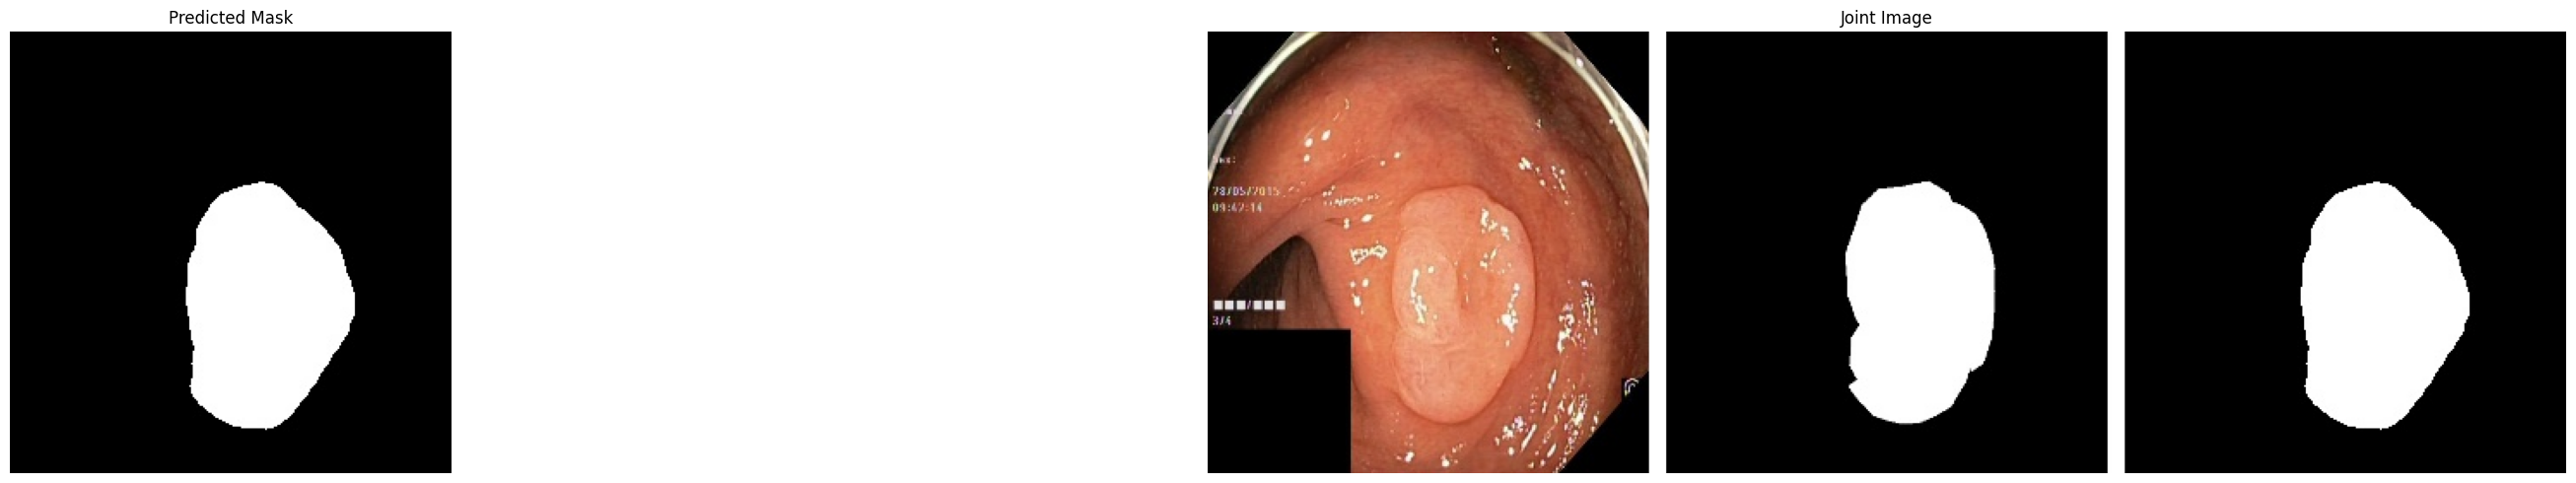

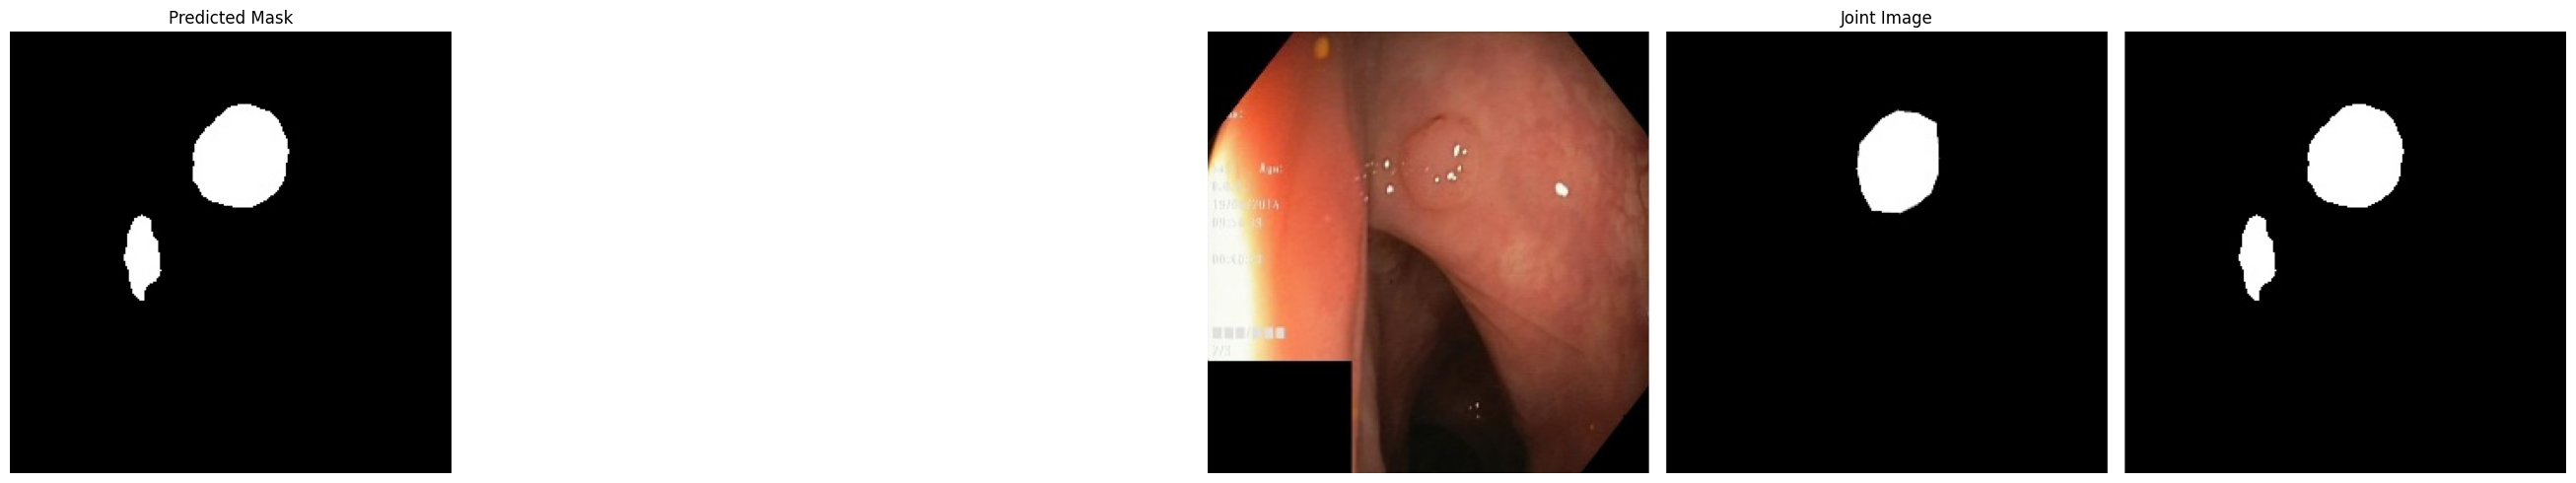

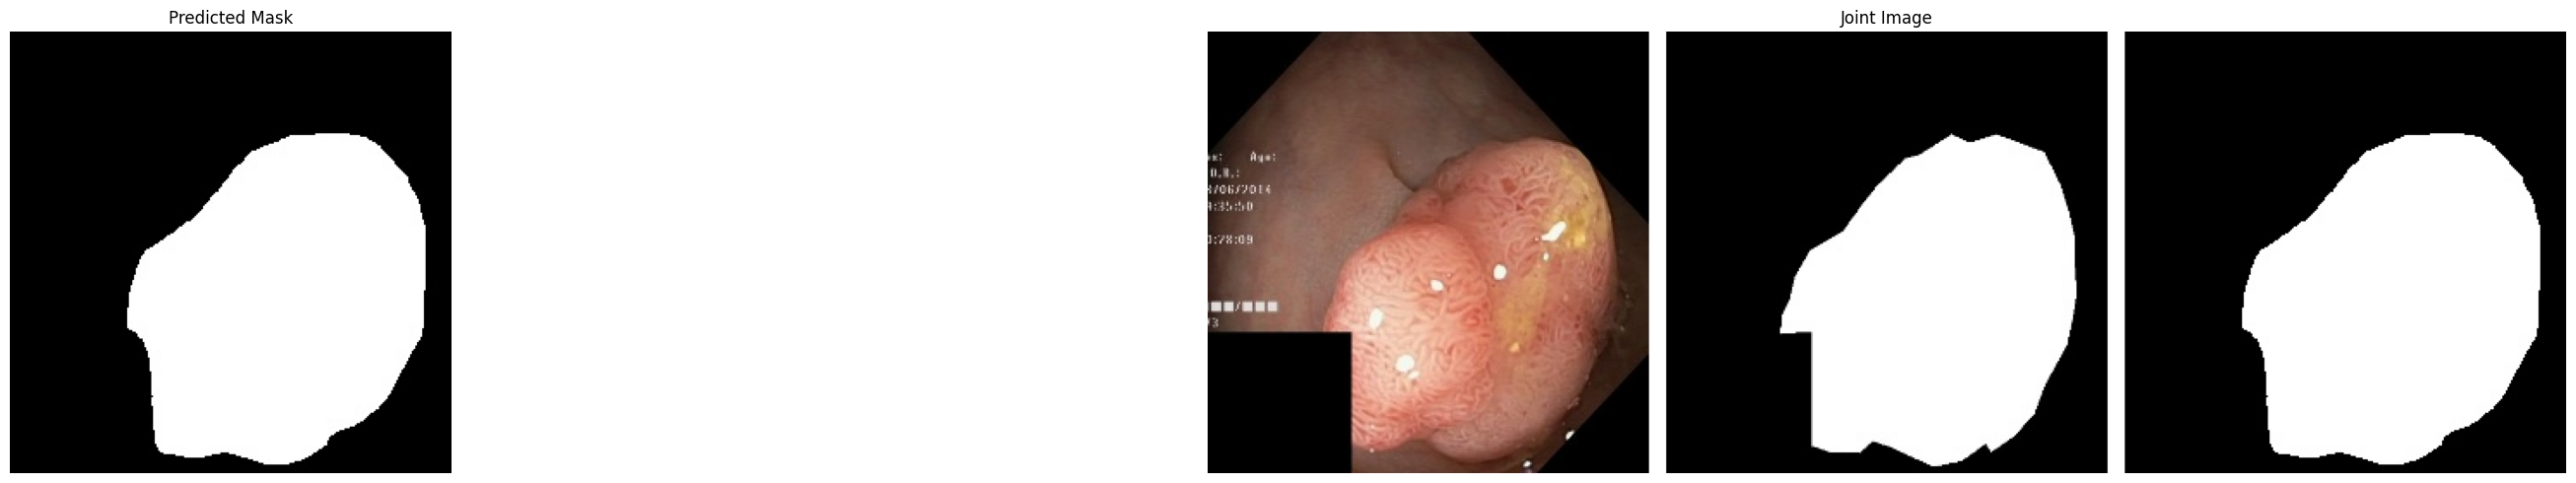

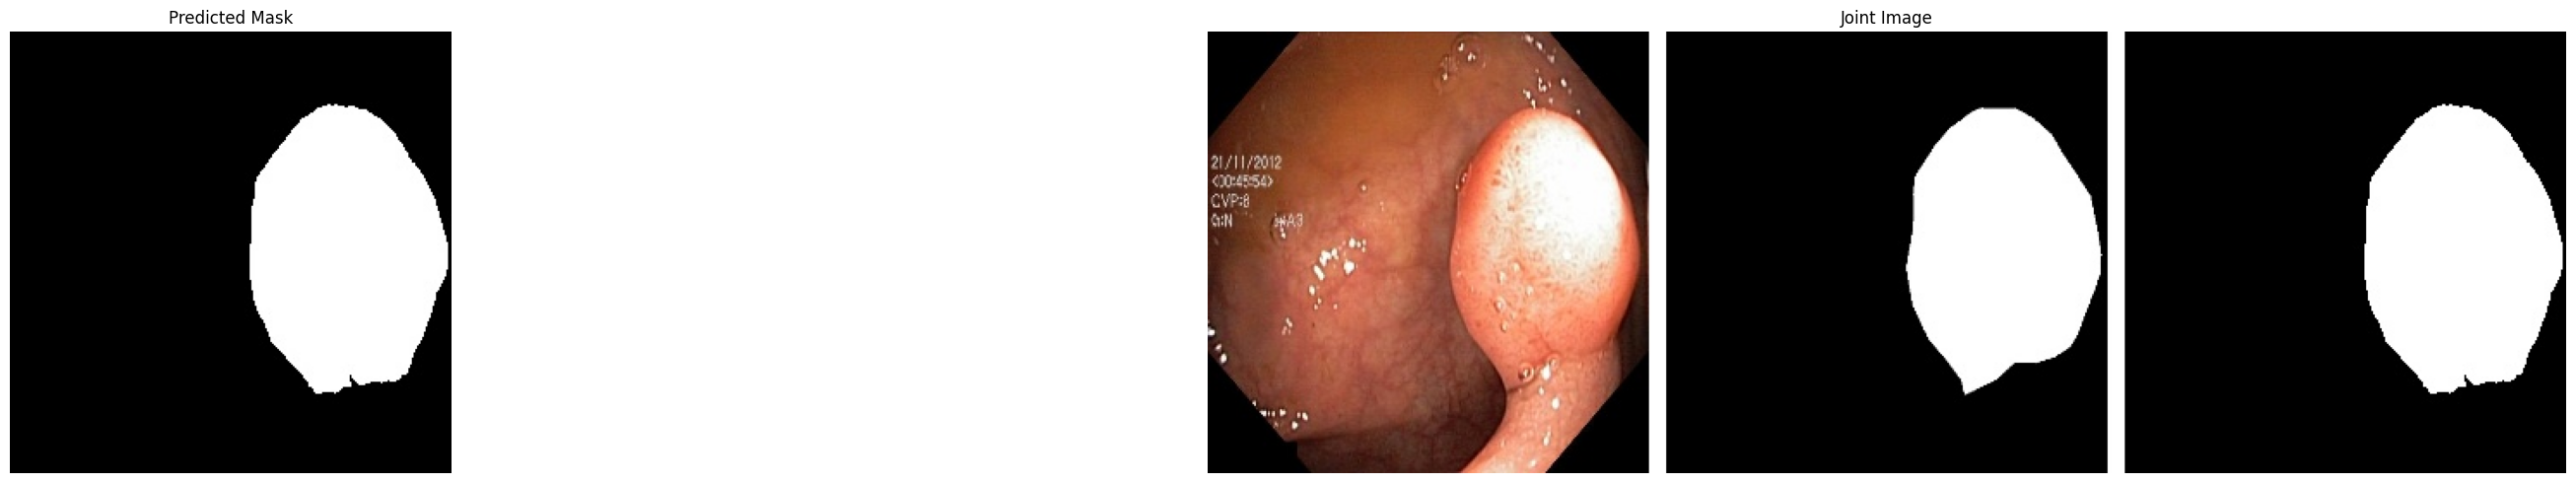

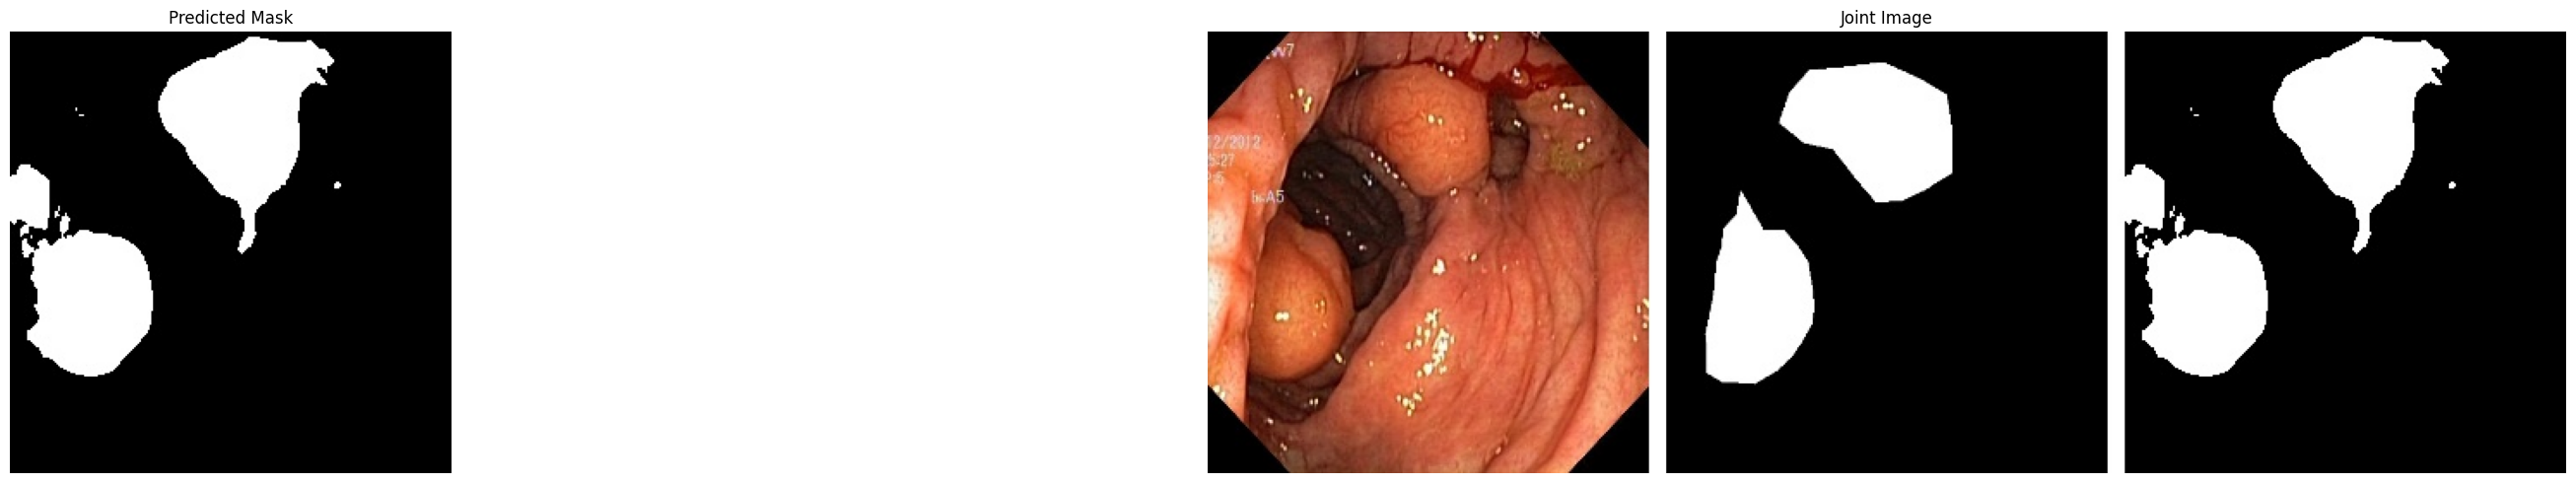

In [31]:
import matplotlib.pyplot as plt
import os

def visualize_results(save_path):
    mask_path = os.path.join(save_path, "mask")
    joint_path = os.path.join(save_path, "joint")

    mask_files = os.listdir(mask_path)
    joint_files = os.listdir(joint_path)

    # Số lượng ảnh trực quan:
    num_images = min(5, len(mask_files))

    for i in range(num_images):
        mask_filename = mask_files[i]
        joint_filename = joint_files[i]

        if mask_filename.endswith(".jpg") and joint_filename.endswith(".jpg"):
            mask_img = plt.imread(os.path.join(mask_path, mask_filename))
            joint_img = plt.imread(os.path.join(joint_path, joint_filename))

            fig, axes = plt.subplots(1, 2, figsize=(40, 5))
            axes[0].imshow(mask_img)
            axes[0].set_title("Predicted Mask")
            axes[0].axis('off')

            axes[1].imshow(joint_img)
            axes[1].set_title("Joint Image")
            axes[1].axis('off')

            plt.tight_layout()
            plt.show()

save_path = "/content/drive/MyDrive/D_Polyp/Polyp/Save_Result_TransNetR/TransNetR"
visualize_results(save_path)